In [47]:
%matplotlib widget

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import signal,stats
import pandas as pd
from typing import Dict
from collections import defaultdict
from ephysvibe.trials.spikes import firing_rate,sp_constants,plot_raster
from ephysvibe.trials import select_trials
from ephysvibe.spike_sorting import config
from ephysvibe.structures.trials_data import TrialsData
from ephysvibe.analysis import raw_ch
from ephysvibe.task import task_constants,def_task
import os, glob

## Load data

In [61]:
directory="/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/plots2/detect_rf/lip"
#directory='/home/INT/losada.c/Documents/codes/EphysVibe/output/lip'

In [62]:
rf_path = os.path.normpath(str(directory) + "/*.csv")
rf_path = glob.glob(rf_path, recursive=True)

In [63]:
rf_all = []
for n_path in rf_path:
    rf = pd.read_csv(n_path)
    rf = rf[~rf.isnull().any(axis=1)]
    rf_all.append(rf)
rf_all = pd.concat(rf_all).reset_index(drop=True)

In [64]:
rf_all.head()

,array_position,neuron_type,i_neuron,event,rad,ang,fr_max,ang_max,rad_all,ang_all,depth,vm_index,date,lat_index,p_lat
0,5,neuron,4,visual,0.832172,0.438803,85.409301,45.0,0.832172,0.438803,1250.0,-0.110176,2023-01-20_11-00-24,0.482330,3.939063e-47
1,5,neuron,4,motor,0.440295,0.413874,42.775212,45.0,0.832172,0.438803,1250.0,-0.110176,2023-01-20_11-00-24,0.482330,3.939063e-47
2,10,mua,3,motor,1.000000,5.497787,12.421879,315.0,1.000000,5.497787,1400.0,0.644634,2023-01-20_11-00-24,0.868517,4.344073e-06
3,5,neuron,4,motor,0.925719,5.497787,20.356090,315.0,0.925719,5.497787,1250.0,0.368148,2023-01-23_10-10-27,0.737143,3.394658e-47
4,7,neuron,6,visual,0.649530,5.497787,51.081949,180.0,0.851170,5.854832,1050.0,0.470888,2023-01-23_10-10-27,0.410848,4.372728e-31


#### Prepare df 

In [65]:
# visual, motor, visuomotor
thres_vm = 0.3
v_df = rf_all[np.logical_and(rf_all['vm_index'] <= -thres_vm,rf_all['event']=='visual')].reset_index(drop=True)
m_df = rf_all[np.logical_and(rf_all['vm_index'] >= thres_vm,rf_all['event']=='motor')].reset_index(drop=True)
v_m_df = rf_all[np.logical_and(rf_all['vm_index'] < thres_vm,rf_all['vm_index']>-thres_vm)].reset_index(drop=True)
v_m_df =v_m_df.drop_duplicates(subset=['date','array_position']).reset_index(drop=True)

print('Total number of neurons: %d'%(len(v_df)+len(m_df)+len(v_m_df)))
print('number of visual %d, motor %d, visualmotor %d'%(len(v_df),len(m_df),len(v_m_df)))

Total number of neurons: 23
number of visual 13, motor 6, visualmotor 4


In [66]:
# ipsi - contra 
rf_no_dup = rf_all.drop_duplicates(subset=['date','array_position']).reset_index(drop=True)
no_pref = rf_no_dup[rf_no_dup['p_lat']>=0.05]
pref= rf_no_dup[rf_no_dup['p_lat']<0.05]
df_contra = pref[pref['lat_index']>=0]
df_ipsi = pref[pref['lat_index']<0]
print('Total number of neurons: %d'%(len(df_ipsi)+len(df_contra)+len(no_pref)))
print('Number of ipsi: %d, contra: %d, no preference: %d'%(len(df_ipsi),len(df_contra),len(no_pref)))

Total number of neurons: 23
Number of ipsi: 3, contra: 18, no preference: 2


In [67]:
# a=rf_all[['date','array_position']].groupby(['date','array_position']).size().reset_index().rename(columns={0:'count'})
# print('Total number of neurons: %d'%len(a))

## Number of ipsi vs number of contra

#### Laterality index

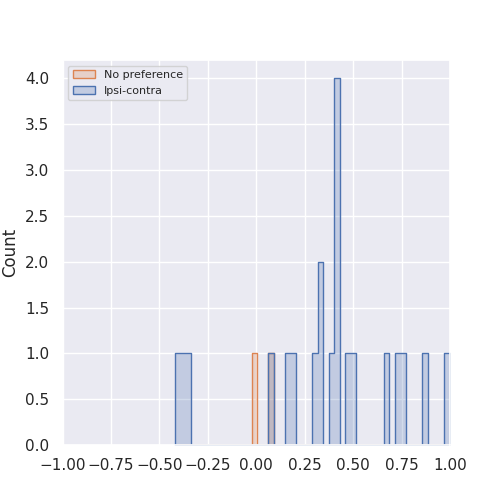

In [68]:
fig,ax = plt.subplots(figsize=(5,5))
ax_pref = sns.histplot([pref['lat_index'].values,no_pref['lat_index'].values], element="step",bins=50, ax=ax)

plt.legend(('No preference','Ipsi-contra'),loc='upper left', bbox_to_anchor=(0, 1), prop={'size': 8})
a=plt.xlim(-1,1)

##### Using the mean angle

Number of ipsi: 2, contra: 21


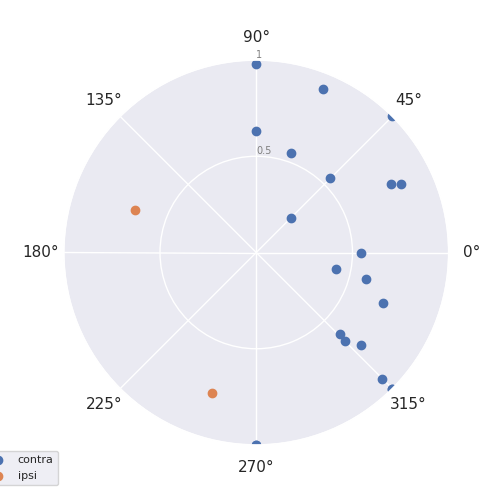

In [69]:
u_lim = 90*np.pi/180
d_lim = 270*np.pi/180

ipsi = rf_no_dup[np.logical_and(rf_no_dup['ang']>u_lim,rf_no_dup['ang']<d_lim)]
contra = rf_no_dup[np.logical_or(rf_no_dup['ang']>=d_lim,rf_no_dup['ang']<=u_lim)]
#plot
fig,ax = plt.subplots(figsize=(5,5),sharex=True,sharey=True,subplot_kw={'projection': 'polar'})
ax.set_rlabel_position(90)
ax.set_yticks([0.5,1], ['0.5','1'], color="grey", size=7)

ax.scatter(contra['ang'],contra['rad'],label='contra')
ax.scatter(ipsi['ang'],ipsi['rad'],label='ipsi')
plt.legend(loc='upper right', bbox_to_anchor=(0, 0), prop={'size': 8})
plt.ylim(0,1)
print('Number of ipsi: %d, contra: %d'%( len(ipsi), len(contra)))

##### Using the mean angle motor/visual

Visual-> number of ipsi: 1, contra: 12
Motor-> number of ipsi: 0, contra: 6


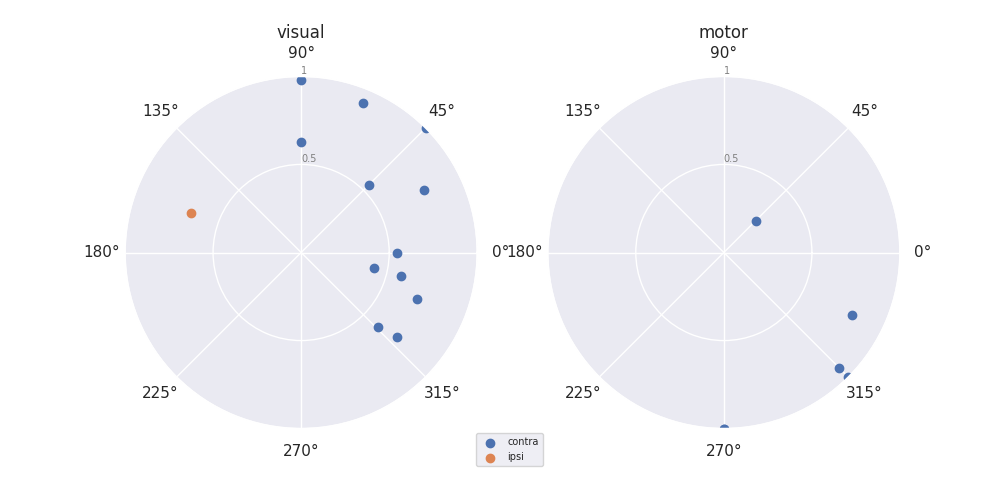

In [70]:
u_lim = 90*np.pi/180
d_lim = 270*np.pi/180
#visual
v_ipsi = v_df[np.logical_and(v_df['ang']>u_lim,v_df['ang']<d_lim)]
v_contra = v_df[np.logical_or(v_df['ang']>=d_lim,v_df['ang']<=u_lim)]
# motor
m_ipsi = m_df[np.logical_and(m_df['ang']>u_lim,m_df['ang']<d_lim)]
m_contra = m_df[np.logical_or(m_df['ang']>=d_lim,m_df['ang']<=u_lim)]
#plot
fig,ax = plt.subplots(1,2,figsize=(10,5),sharex=True,sharey=True,subplot_kw={'projection': 'polar'})
ax[0].set_rlabel_position(90)
ax[0].set_yticks([0.5,1], ['0.5','1'], color="grey", size=7)
ax[1].set_rlabel_position(90)
ax[1].set_yticks([0.5,1], ['0.5','1'], color="grey", size=7)

ax[0].scatter(v_contra['ang'],v_contra['rad'],label='contra')
ax[0].scatter(v_ipsi['ang'],v_ipsi['rad'],label='ipsi')
ax[1].scatter(m_contra['ang'],m_contra['rad'],label='contra')
ax[1].scatter(m_ipsi['ang'],m_ipsi['rad'],label='ipsi')
plt.ylim(0,1)
ax[0].set_title('visual')
ax[1].set_title('motor')
plt.legend(loc='upper right', bbox_to_anchor=(0, 0), prop={'size': 7})
print('Visual-> number of ipsi: %d, contra: %d'%( len(v_ipsi), len(v_contra)))
print('Motor-> number of ipsi: %d, contra: %d'%( len(m_ipsi), len(m_contra)))

##### Using the position
contra: 90, 45, 0, 315
ipsi: 135, 180, 225, 270

Visual-> number of ipsi: 3, contra: 10
Motor-> number of ipsi: 2, contra: 4


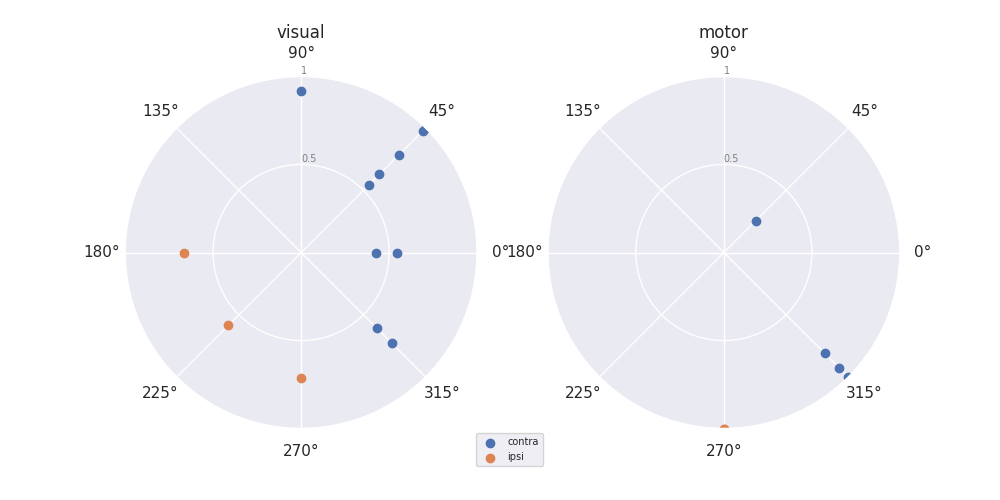

In [71]:
u_lim = 100
d_lim = 280
#visual
v_ipsi = v_df[np.logical_and(v_df['ang_max']>u_lim,v_df['ang_max']<d_lim)]
v_contra = v_df[np.logical_or(v_df['ang_max']>=d_lim,v_df['ang_max']<=u_lim)]
# motor
m_ipsi = m_df[np.logical_and(m_df['ang_max']>u_lim,m_df['ang_max']<d_lim)]
m_contra = m_df[np.logical_or(m_df['ang_max']>=d_lim,m_df['ang_max']<=u_lim)]
#plot
fig,ax = plt.subplots(1,2,figsize=(10,5),sharex=True,sharey=True,subplot_kw={'projection': 'polar'})
ax[0].set_rlabel_position(90)
ax[0].set_yticks([0.5,1], ['0.5','1'], color="grey", size=7)
ax[1].set_rlabel_position(90)
ax[1].set_yticks([0.5,1], ['0.5','1'], color="grey", size=7)
ax[0].scatter(v_contra['ang_max']*np.pi/180,v_contra['rad'],label='contra')
ax[0].scatter(v_ipsi['ang_max']*np.pi/180,v_ipsi['rad'],label='ipsi')
ax[1].scatter(m_contra['ang_max']*np.pi/180,m_contra['rad'],label='contra')
ax[1].scatter(m_ipsi['ang_max']*np.pi/180,m_ipsi['rad'],label='ipsi')
plt.ylim(0,1)
ax[0].set_title('visual')
ax[1].set_title('motor')
ax[1].legend(loc='upper right', bbox_to_anchor=(0, 0), prop={'size': 7})
print('Visual-> number of ipsi: %d, contra: %d'%( len(v_ipsi), len(v_contra)))
print('Motor-> number of ipsi: %d, contra: %d'%( len(m_ipsi), len(m_contra)))

#### Using mean angle all

Number of no_pref: 2, pref: 21


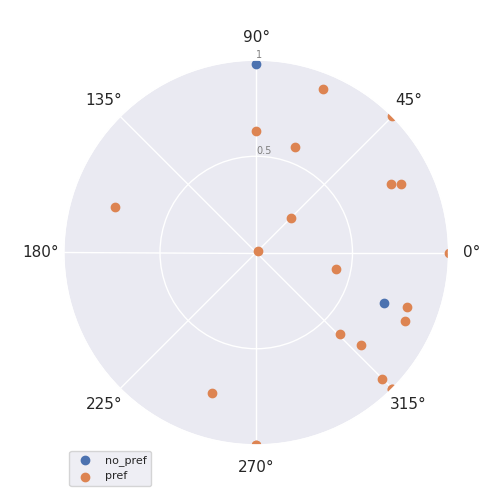

In [72]:
#plot
fig,ax = plt.subplots(figsize=(5,5),subplot_kw={'projection': 'polar'})
ax.set_rlabel_position(90)
ax.set_yticks([0.5,1], ['0.5','1'], color="grey", size=7)

ax.scatter(no_pref['ang_all'],no_pref['rad_all'],label='no_pref')
ax.scatter(pref['ang_all'],pref['rad_all'],label='pref')
ax.legend(loc='upper left', bbox_to_anchor=(0, 0), prop={'size': 8})
ax.set_ylim(0,1)
print('Number of no_pref: %d, pref: %d'%( len(no_pref), len(pref)))

# Spatial location

In [73]:
df_depth = pd.read_csv("/home/INT/losada.c/Downloads/recordings_info.csv")[['file_name','depth_in_lip','locacion_p','locacion_l']]
rf_depth = rf_all.merge(df_depth, left_on='date', right_on='file_name')
rf_depth['total_depth'] =  rf_depth['depth'] *(rf_depth['depth_in_lip']*1000) /1600

In [74]:
# visual, motor, visuomotor
thres_vm = 0.3
v_df_depth = rf_depth[np.logical_and(rf_depth['vm_index'] <= -thres_vm,rf_depth['event']=='visual')].reset_index(drop=True)
m_df_depth = rf_depth[np.logical_and(rf_depth['vm_index'] >= thres_vm,rf_depth['event']=='motor')].reset_index(drop=True)
v_m_df_depth = rf_depth[np.logical_and(rf_depth['vm_index'] < thres_vm,rf_depth['vm_index']>-thres_vm)].reset_index(drop=True)
v_m_df_depth =v_m_df_depth.drop_duplicates(subset=['date','array_position']).reset_index(drop=True)

print('Total number of neurons: %d'%(len(v_df_depth)+len(m_df_depth)+len(v_m_df_depth)))
print('number of visual %d, motor %d, visualmotor %d'%(len(v_df_depth),len(m_df_depth),len(v_m_df_depth)))

Total number of neurons: 23
number of visual 13, motor 6, visualmotor 4


In [75]:
# ipsi - contra 
rf_depth_no_dup = rf_depth.drop_duplicates(subset=['date','array_position']).reset_index(drop=True)
no_pref_depth = rf_depth_no_dup[rf_depth_no_dup['p_lat']>=0.05]
pref_depth= rf_depth_no_dup[rf_depth_no_dup['p_lat']<0.05]
df_contra_depth = pref_depth[pref_depth['lat_index']>=0]
df_ipsi_depth = pref_depth[pref_depth['lat_index']<0]
print('Total number of neurons: %d'%(len(df_ipsi_depth)+len(df_contra_depth)+len(no_pref_depth)))
print('Number of ipsi: %d, contra: %d, no preference: %d'%(len(df_ipsi_depth),len(df_contra_depth),len(no_pref_depth)))

Total number of neurons: 23
Number of ipsi: 3, contra: 18, no preference: 2


### visual - motor

Number of motor: 6, visual: 13


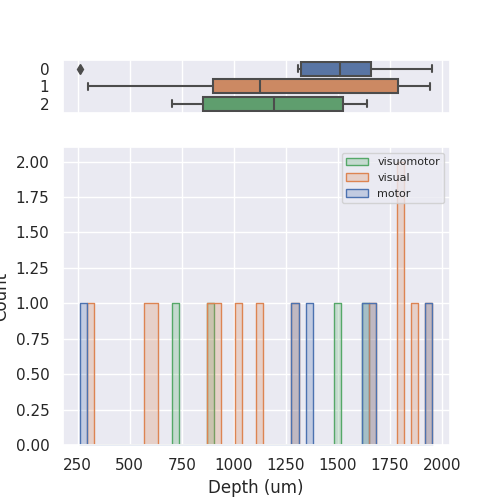

In [76]:
sns.set(style="darkgrid")

print('Number of motor: %d, visual: %d'%( len(m_df_depth), len(v_df_depth)))
fig,(ax_box, ax_hist) = plt.subplots(2, sharex=True,figsize=(5,5), gridspec_kw={"height_ratios": (.15, .85)})
sns.boxplot([m_df_depth['total_depth'].values,v_df_depth['total_depth'].values,v_m_df_depth['total_depth'].values], ax=ax_box,orient='horizontal')
sns.histplot([m_df_depth['total_depth'].values,v_df_depth['total_depth'].values,v_m_df_depth['total_depth'].values], element="step",bins=50, ax=ax_hist,legend=True)
ax_hist.set_xlabel('Depth (um)')
plt.legend(['visuomotor', 'visual','motor'], prop={'size': 8})


Number of motor: 6, visual: 13
Number of motor: 6, visual: 13


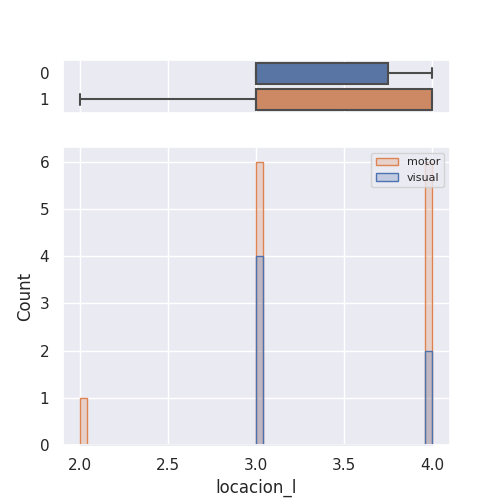

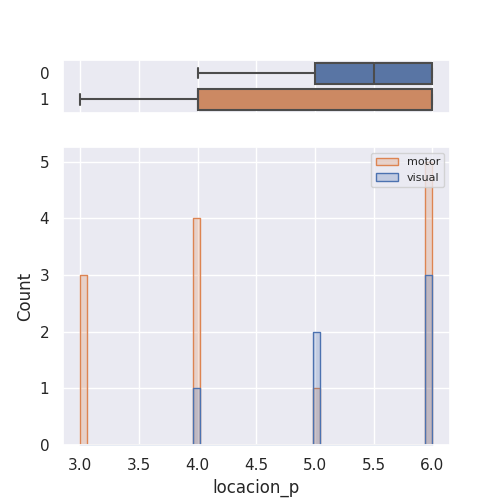

In [77]:
sns.set(style="darkgrid")
rf_motor = m_df_depth['locacion_l']
rf_visual = v_df_depth['locacion_l']

print('Number of motor: %d, visual: %d'%( len(rf_motor), len(rf_visual)))
fig,(ax_box, ax_hist) = plt.subplots(2, sharex=True,figsize=(5,5), gridspec_kw={"height_ratios": (.15, .85)})
sns.boxplot([rf_motor.values,rf_visual.values], ax=ax_box,orient='horizontal')
sns.histplot([rf_motor.values,rf_visual.values], element="step",bins=50, ax=ax_hist,legend=True)
ax_hist.set_xlabel('locacion_l')
plt.legend(['motor', 'visual'], prop={'size': 8})

rf_motor = m_df_depth['locacion_p']
rf_visual = v_df_depth['locacion_p']

print('Number of motor: %d, visual: %d'%( len(rf_motor), len(rf_visual)))
fig,(ax_box, ax_hist) = plt.subplots(2, sharex=True,figsize=(5,5), gridspec_kw={"height_ratios": (.15, .85)})
sns.boxplot([rf_motor.values,rf_visual.values], ax=ax_box,orient='horizontal')
sns.histplot([rf_motor.values,rf_visual.values], element="step",bins=50, ax=ax_hist,legend=True)
ax_hist.set_xlabel('locacion_p')
plt.legend(['motor', 'visual'], prop={'size': 8})

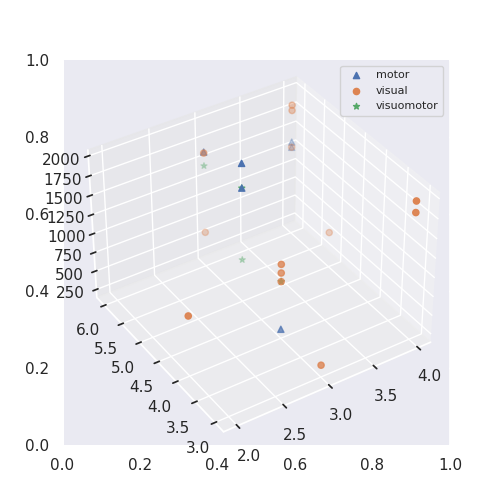

In [78]:
sns.set(style="darkgrid")
l_motor = m_df_depth['locacion_l']
p_motor = m_df_depth['locacion_p']
d_motor = m_df_depth['total_depth']
l_visual = v_df_depth['locacion_l']
p_visual = v_df_depth['locacion_p']
d_visual = v_df_depth['total_depth']
l_v_m = v_m_df_depth['locacion_l']
p_v_m = v_m_df_depth['locacion_p']
d_v_m = v_m_df_depth['total_depth']


fig,ax = plt.subplots(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(l_motor.values,p_motor.values,d_motor.values,marker='^')
ax.scatter(l_visual.values,p_visual.values,d_visual.values)
ax.scatter(l_v_m.values,p_v_m.values,d_v_m.values,marker='*')
#sns.scatterplot(x=l_visual.values,y=p_visual.values, ax=ax)
#ax_hist.set_xlabel('locacion_l')
plt.legend(['motor', 'visual','visuomotor'], prop={'size': 8})
ax.view_init(37, -123)
plt.show()

In [79]:
plt.close()

Text(0.5, 1.0, 'visuomotor')

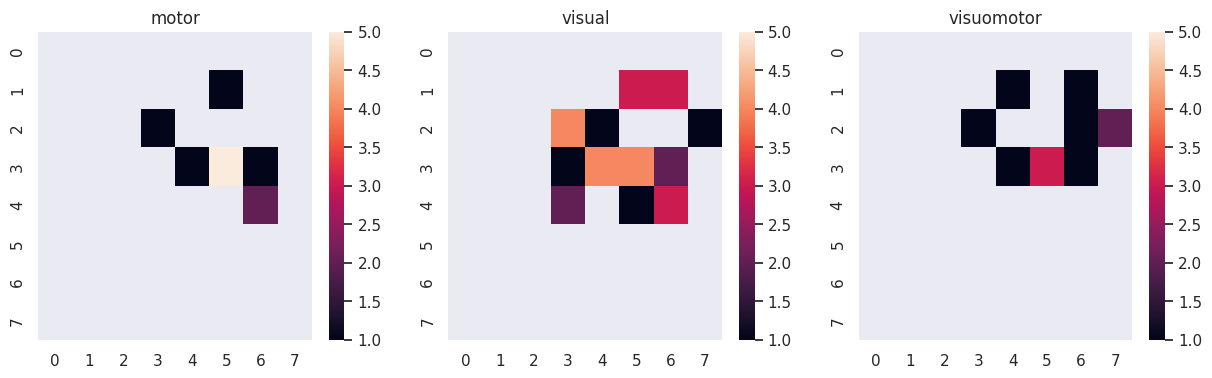

No such comm: 7c385e3c68504b75b34e274227c09496


Text(0.5, 1.0, 'visuomotor')

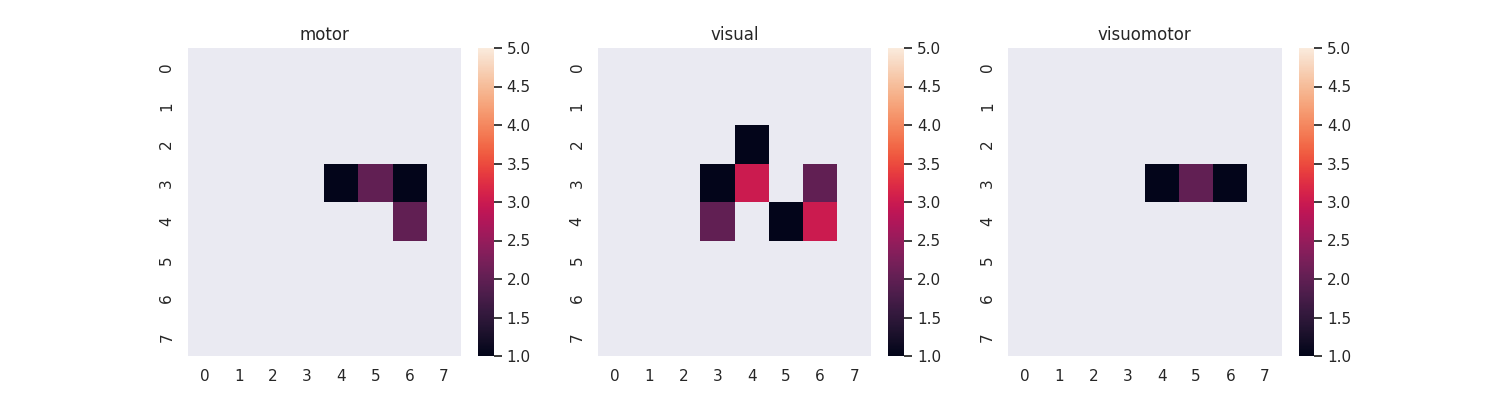

In [80]:
vmax = 5
count_df_m = m_df_depth[['locacion_l','locacion_p']].groupby(['locacion_l','locacion_p']).size().reset_index().rename(columns={0:'count'})
count_df_v = v_df_depth[['locacion_l','locacion_p']].groupby(['locacion_l','locacion_p']).size().reset_index().rename(columns={0:'count'})
count_df_vm = v_m_df_depth[['locacion_l','locacion_p']].groupby(['locacion_l','locacion_p']).size().reset_index().rename(columns={0:'count'})

m_vals=count_df_m.pivot_table(index = ['locacion_l'] ,columns=['locacion_p'],values='count')
v_vals=count_df_v.pivot_table(index = 'locacion_l' ,columns='locacion_p',values='count')
vm_vals=count_df_vm.pivot_table(index = 'locacion_l' ,columns='locacion_p',values='count')

m_vals.columns.name = None 
m_vals.index.name=None
m_vals_all=np.full((8,8),np.nan)
m_vals_all[m_vals.index[0]:m_vals.index[-1]+1, m_vals.columns[0]:m_vals.columns[-1]+1]=m_vals
v_vals.columns.name = None 
v_vals.index.name=None
v_vals_all=np.full((8,8),np.nan)
v_vals_all[v_vals.index[0]:v_vals.index[-1]+1, v_vals.columns[0]:v_vals.columns[-1]+1]=v_vals
vm_vals.columns.name = None 
vm_vals.index.name=None
vm_vals_all=np.full((8,8),np.nan)
vm_vals_all[vm_vals.index[0]:vm_vals.index[-1]+1, vm_vals.columns[0]:vm_vals.columns[-1]+1]=vm_vals
fig,(ax_m,ax_v,ax_vm) = plt.subplots(ncols=3,figsize=(15,4))
sns.heatmap(m_vals_all,ax=ax_m,vmax=vmax)
sns.heatmap(v_vals_all,ax=ax_v,vmax=vmax)
sns.heatmap(vm_vals_all,ax=ax_vm,vmax=vmax)
ax_m.set_title('motor')
ax_v.set_title('visual')
ax_vm.set_title('visuomotor')

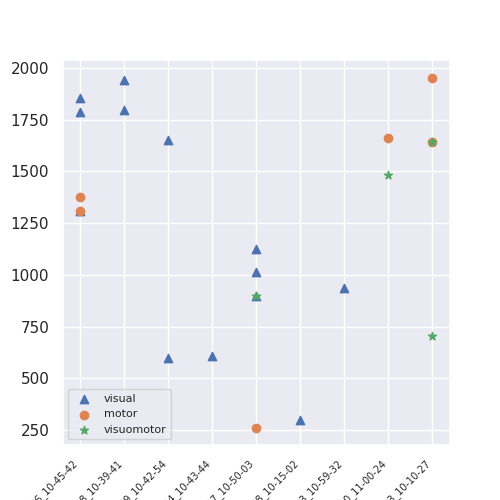

In [81]:
dt_v = v_df_depth['date']
d_v = v_df_depth['total_depth']
dt_m = m_df_depth['date']
d_m = m_df_depth['total_depth']
dt_vm = v_m_df_depth['date']
d_vm = v_m_df_depth['total_depth']
fig,ax = plt.subplots(figsize=(5,5))

ax.scatter(dt_v.values,d_v.values,marker='^')
ax.scatter(dt_m.values,d_m.values)
ax.scatter(dt_vm.values,d_vm.values,marker='*')
plt.xticks(rotation=45, ha='right',size=7)
plt.legend(['visual', 'motor','visuomotor'], prop={'size': 8})

plt.show()

### Laterality

In [82]:
my_colors = {0: 'purple', 1: 'pink', 2: 'gold'}

0.2790595299610021


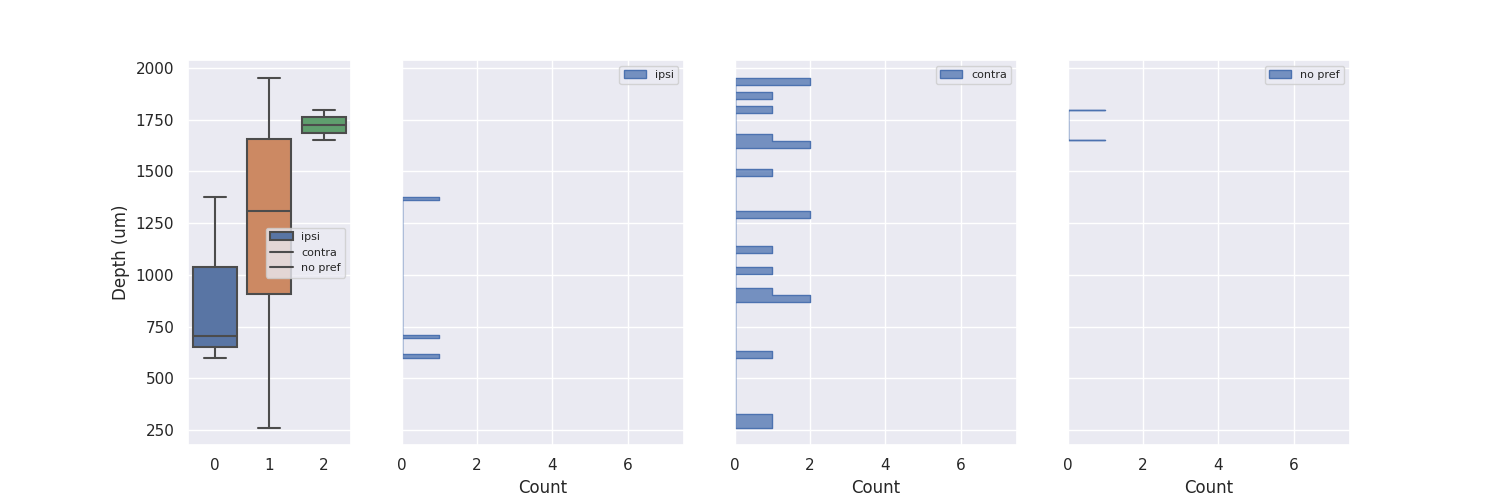

In [83]:
sns.set(style="darkgrid")


rf_dep_no_sig = no_pref_depth['total_depth']
rf_dep_sig = pref_depth

rf_contra = df_contra_depth['total_depth']
rf_ipsi = df_ipsi_depth['total_depth']


fig,(ax_box, ax1,ax2,ax3) = plt.subplots(1,4, sharey=True,figsize=(15,5), gridspec_kw={"width_ratios": (.11, .19,0.19,0.19)})
g = sns.boxplot([rf_ipsi.values,rf_contra.values,rf_dep_no_sig.values], ax=ax_box,orient='vertical')#,palette=my_colors)
g.legend(('ipsi', 'contra','no pref'), prop={'size': 8})
g.set_ylabel('Depth (um)')
g1=sns.histplot(y=rf_ipsi.values, element="step",bins=50,ax=ax1,legend=True)
g1.legend(['ipsi'], prop={'size': 8})
ax1.set_xlim(0,7.5)
g2=sns.histplot(y=rf_contra.values, element="step",bins=50,ax=ax2,legend=True)
g2.legend(['contra'], prop={'size': 8})
ax2.set_xlim(0,7.5)
g3=sns.histplot(y=rf_dep_no_sig.values, element="step",bins=50, ax=ax3,legend=True)
g3.legend(['no pref'], prop={'size': 8})
ax3.set_xlim(0,7.5)
#sns.histplot([rf_dep_no_sig.values], element="step",bins=50,ax=ax3,legend=True)
p=stats.ttest_ind(rf_ipsi.values, rf_contra.values)[1]
print(p)

/tmp/ipykernel_95912/2037442971.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,(ax_box, ax1,ax2,ax3) = plt.subplots(1,4, sharey=True,figsize=(15,5), gridspec_kw={"width_ratios": (.11, .19,0.19,0.19)})


0.8784680484060998
0.17849248796752498


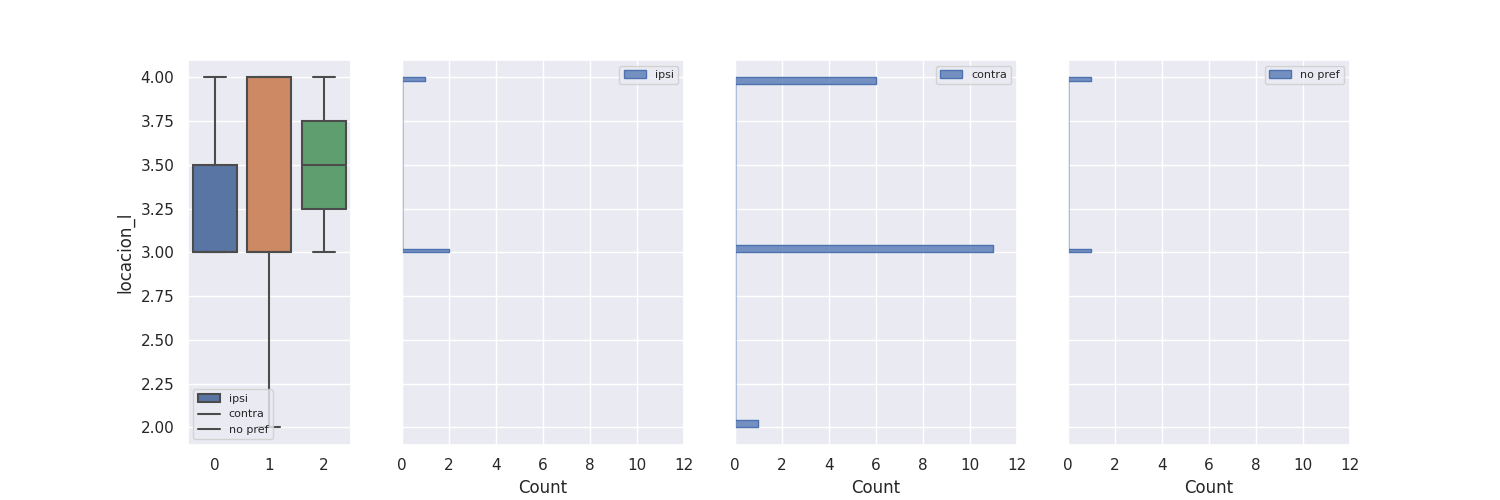

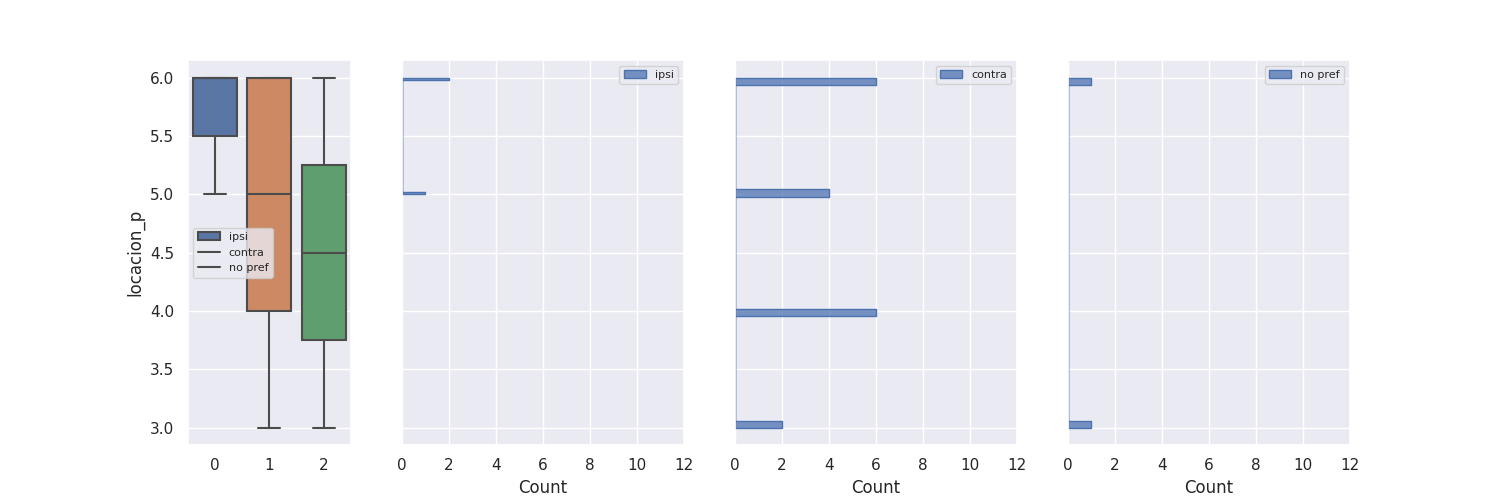

In [84]:
sns.set(style="darkgrid")

rf_dep_no_sig = no_pref_depth['locacion_l']
rf_dep_sig = pref_depth
rf_contra = df_contra_depth['locacion_l']
rf_ipsi = df_ipsi_depth['locacion_l']
fig,(ax_box, ax1,ax2,ax3) = plt.subplots(1,4, sharey=True,figsize=(15,5), gridspec_kw={"width_ratios": (.11, .19,0.19,0.19)})
g = sns.boxplot([rf_ipsi.values,rf_contra.values,rf_dep_no_sig.values], ax=ax_box,orient='vertical')#,palette=my_colors)
g.legend(['ipsi', 'contra','no pref'], prop={'size': 8})
g.set_ylabel('locacion_l')
g1=sns.histplot(y=rf_ipsi.values, element="step",bins=50,ax=ax1,legend=True)
g1.legend(['ipsi'], prop={'size': 8})
ax1.set_xlim(0,12)
g2=sns.histplot(y=rf_contra.values, element="step",bins=50,ax=ax2,legend=True)
g2.legend(['contra'], prop={'size': 8})
ax2.set_xlim(0,12)
g3=sns.histplot(y=rf_dep_no_sig.values, element="step",bins=50, ax=ax3,legend=True)
g3.legend(['no pref'], prop={'size': 8})
ax3.set_xlim(0,12)
#sns.histplot([rf_dep_no_sig.values], element="step",bins=50,ax=ax3,legend=True)
p=stats.ttest_ind(rf_ipsi.values, rf_contra.values)[1]
print(p)

rf_dep_no_sig = no_pref_depth['locacion_p']
rf_dep_sig = pref_depth
rf_contra = df_contra_depth['locacion_p']
rf_ipsi = df_ipsi_depth['locacion_p']
fig,(ax_box, ax1,ax2,ax3) = plt.subplots(1,4, sharey=True,figsize=(15,5), gridspec_kw={"width_ratios": (.11, .19,0.19,0.19)})
g = sns.boxplot([rf_ipsi.values,rf_contra.values,rf_dep_no_sig.values], ax=ax_box,orient='vertical')#,palette=my_colors)
g.legend(['ipsi', 'contra','no pref'], prop={'size': 8})
g.set_ylabel('locacion_p')
g1=sns.histplot(y=rf_ipsi.values, element="step",bins=50,ax=ax1,legend=True)
g1.legend(['ipsi'], prop={'size': 8})
ax1.set_xlim(0,12)
g2=sns.histplot(y=rf_contra.values, element="step",bins=50,ax=ax2,legend=True)
g2.legend(['contra'], prop={'size': 8})
ax2.set_xlim(0,12)
g3=sns.histplot(y=rf_dep_no_sig.values, element="step",bins=50, ax=ax3,legend=True)
g3.legend(['no pref'], prop={'size': 8})
ax3.set_xlim(0,12)
#sns.histplot([rf_dep_no_sig.values], element="step",bins=50,ax=ax3,legend=True)
p=stats.ttest_ind(rf_ipsi.values, rf_contra.values)[1]
print(p)

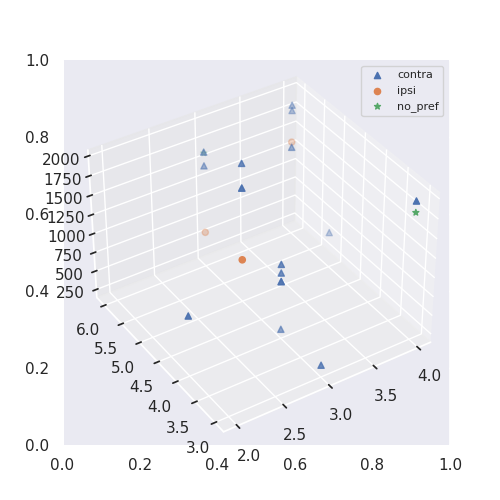

In [85]:
sns.set(style="darkgrid")
l_contra = df_contra_depth['locacion_l']
p_contra = df_contra_depth['locacion_p']
d_contra = df_contra_depth['total_depth']
l_ipsi = df_ipsi_depth['locacion_l']
p_ipsi = df_ipsi_depth['locacion_p']
d_ipsi = df_ipsi_depth['total_depth']
l_no_pref = no_pref_depth['locacion_l']
p_no_pref = no_pref_depth['locacion_p']
d_no_pref = no_pref_depth['total_depth']


fig,ax = plt.subplots(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(l_contra.values,p_contra.values,d_contra.values,marker='^')
ax.scatter(l_ipsi.values,p_ipsi.values,d_ipsi.values)
ax.scatter(l_no_pref.values,p_no_pref.values,d_no_pref.values,marker='*')
#sns.scatterplot(x=l_visual.values,y=p_visual.values, ax=ax)
#ax_hist.set_xlabel('locacion_l')
plt.legend(['contra', 'ipsi','no_pref'], prop={'size': 8})
ax.view_init(37, -123)
plt.show()

In [86]:
vmax = 5
count_df_contra = df_contra_depth[['locacion_l','locacion_p']].groupby(['locacion_l','locacion_p']).size().reset_index().rename(columns={0:'count'})
count_df_ipsi = df_ipsi_depth[['locacion_l','locacion_p']].groupby(['locacion_l','locacion_p']).size().reset_index().rename(columns={0:'count'})
count_df_nopref = no_pref_depth[['locacion_l','locacion_p']].groupby(['locacion_l','locacion_p']).size().reset_index().rename(columns={0:'count'})

contra_vals=count_df_contra.pivot_table(index = ['locacion_l'] ,columns=['locacion_p'],values='count')
ipsi_vals=count_df_ipsi.pivot_table(index = 'locacion_l' ,columns='locacion_p',values='count')
nopref_vals=count_df_nopref.pivot_table(index = 'locacion_l' ,columns='locacion_p',values='count')

contra_vals.columns.name = None 
contra_vals.index.name=None
contra_vals_all=np.full((7,7),np.nan)
contra_vals_all[contra_vals.index[0]:contra_vals.index[-1]+1, contra_vals.columns[0]:contra_vals.columns[-1]+1]=contra_vals
ipsi_vals.columns.name = None 
ipsi_vals.index.name=None
ipsi_vals_all=np.full((7,7),np.nan)
ipsi_vals_all[ipsi_vals.index[0]:ipsi_vals.index[-1]+1, ipsi_vals.columns[0]:ipsi_vals.columns[-1]+1]=ipsi_vals
nopref_vals.columns.name = None 
nopref_vals.index.name=None
nopref_vals_all=np.full((7,7),np.nan)
nopref_vals_all[nopref_vals.index[0]:nopref_vals.index[-1]+1, nopref_vals.columns[0]:nopref_vals.columns[-1]+1]=nopref_vals
fig,(ax_contra,ax_ipsi,ax_nopref) = plt.subplots(ncols=3,figsize=(15,4))
sns.heatmap(contra_vals_all,ax=ax_contra,vmax=vmax)
sns.heatmap(ipsi_vals_all,ax=ax_ipsi,vmax=vmax)
sns.heatmap(nopref_vals_all,ax=ax_nopref,vmax=vmax)
ax_contra.set_title('contra')
ax_ipsi.set_title('ipsi')
ax_nopref.set_title('nopref')

ValueError: could not broadcast input array from shape (2,2) into shape (2,4)

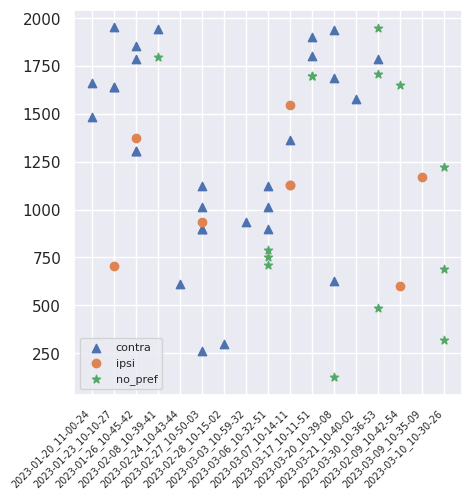

In [ ]:
dt_contra = df_contra_depth['date']
d_contra = df_contra_depth['total_depth']
dt_ipsi = df_ipsi_depth['date']
d_ipsi = df_ipsi_depth['total_depth']
dt_no_pref = no_pref_depth['date']
d_no_pref = no_pref_depth['total_depth']
fig,ax = plt.subplots(figsize=(5,5))

ax.scatter(dt_contra.values,d_contra.values,marker='^')
ax.scatter(dt_ipsi.values,d_ipsi.values)
ax.scatter(dt_no_pref.values,d_no_pref.values,marker='*')
plt.xticks(rotation=45, ha='right',size=7)
plt.legend(['contra', 'ipsi','no_pref'], prop={'size': 8})

plt.show()

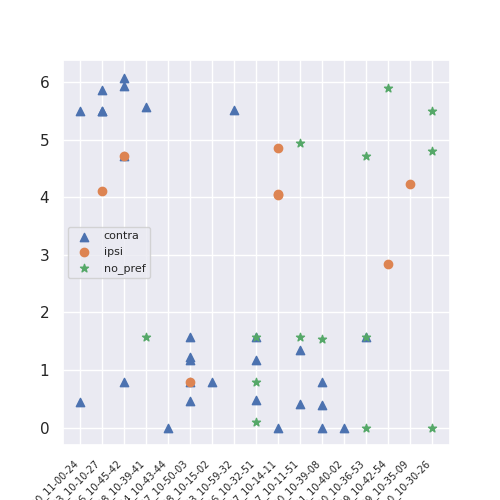

In [ ]:
dt_contra = df_contra_depth['date']
d_contra = df_contra_depth['ang_all']
dt_ipsi = df_ipsi_depth['date']
d_ipsi = df_ipsi_depth['ang_all']
dt_no_pref = no_pref_depth['date']
d_no_pref = no_pref_depth['ang_all']
fig,ax = plt.subplots(figsize=(5,5))

ax.scatter(dt_contra.values,d_contra.values,marker='^')
ax.scatter(dt_ipsi.values,d_ipsi.values)
ax.scatter(dt_no_pref.values,d_no_pref.values,marker='*')
plt.xticks(rotation=45, ha='right',size=7)
plt.legend(['contra', 'ipsi','no_pref'], prop={'size': 8})

plt.show()